In [1]:
!pip install shap imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import shap

# Load the dataset
data = pd.read_csv('66c0115acc881_epic6_cx_data_analytics_case_2.csv')  # Replace with your file path

# Display the first few rows
print(data.head())

# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Data types of the columns (no parentheses)
print(data.dtypes)


In [ ]:
# Check available columns
print(data.columns)


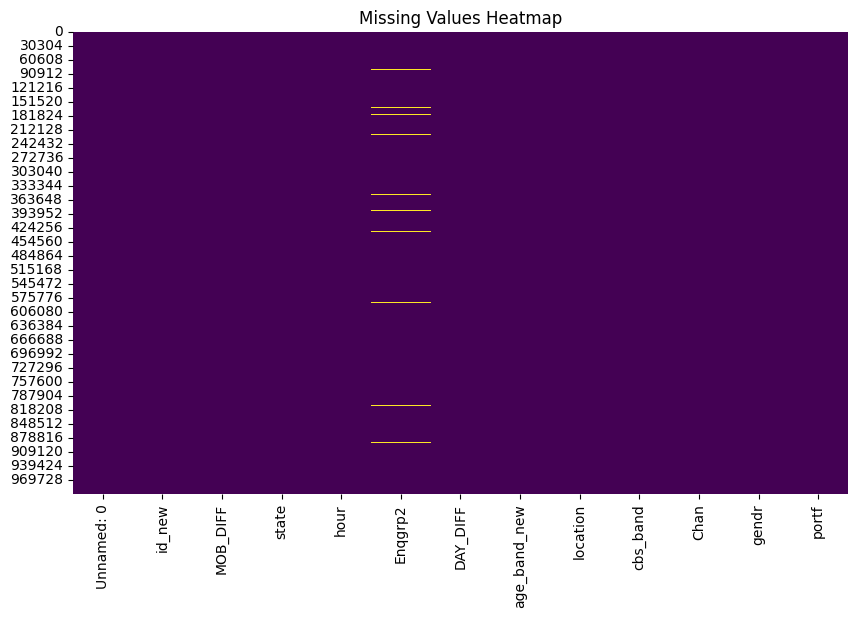

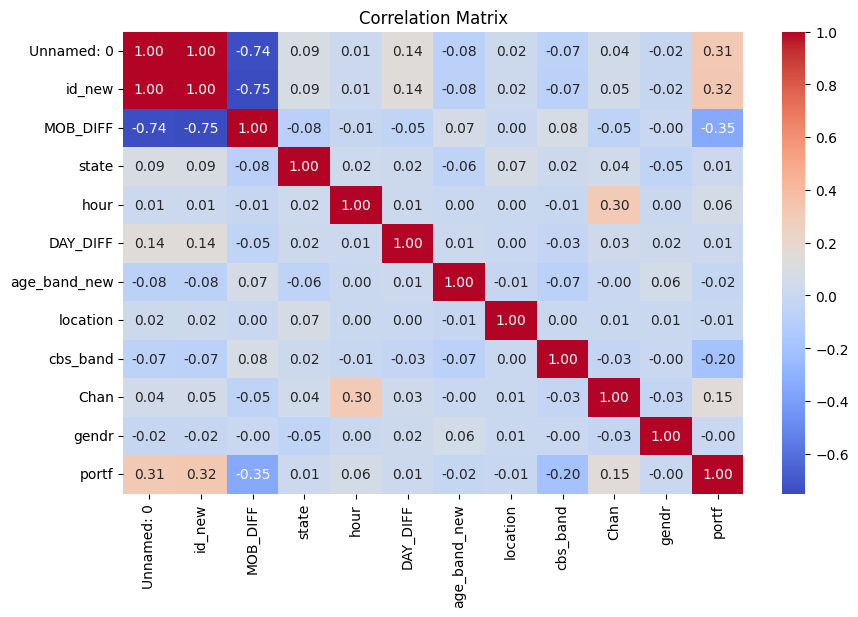

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7c2ee26113f0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7c2ee2610670> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (make sure to update the file path to where your dataset is stored)
data = pd.read_csv('66c0115acc881_epic6_cx_data_analytics_case_2.csv')  # Update this path accordingly

# 1. Visualize Missing Values (Reduced Figure Size)
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# 2. Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number]).dropna()

# 3. Correlation Matrix (Sampled Data)
corr_sample = numeric_data.sample(frac=0.3, random_state=42)  # Reduce data size for faster processing
plt.figure(figsize=(10, 6))
sns.heatmap(corr_sample.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 4. Drop rows with missing values for pairplot (Subsample Data)
clean_data = data.dropna(subset=['Chan'])
pairplot_sample = clean_data.sample(frac=0.2, random_state=42)  # Subsample for faster processing
sns.pairplot(pairplot_sample, hue='Chan')
plt.show()

# 5. Distribution of Numerical Features (Reduced Columns and Subsampling)
columns_to_plot = ['age_band_new', 'DAY_DIFF', 'cbs_band']
for column in columns_to_plot:
    plt.figure()
    sns.histplot(data[column].dropna().sample(frac=0.2, random_state=42), kde=True)  # Subsample for speed
    plt.title(f'Distribution of {column}')
    plt.show()

# 6. Boxplot for Outliers (Subsampling Data)
for column in columns_to_plot:
    plt.figure()
    sns.boxplot(data[column].dropna().sample(frac=0.2, random_state=42))  # Subsample for speed
    plt.title(f'Boxplot of {column}')
    plt.show()


In [ ]:
# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Encoding categorical variables
categorical_features = ['State', 'Location', 'portf']
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(data_imputed[categorical_features])

# Combine encoded features with the original dataset (excluding original categorical columns)
X = pd.concat([data_imputed.drop(columns=categorical_features), pd.DataFrame(encoded_features)], axis=1)

# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['AGE_BAND_NEW', 'DAY_DIFF', 'cbs_band']
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Target variable
y = data_imputed['chan']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
# Ensure 'DAY_DIFF' is in datetime format
X_resampled['day_of_week'] = pd.to_datetime(data_imputed['DAY_DIFF']).dt.dayofweek
X_resampled['is_weekend'] = X_resampled['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Model Training
model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Cross-Validation Score
cv_score = cross_val_score(best_model, X_resampled, y_resampled, cv=5)
print(f'Cross-Validation Score: {cv_score.mean()}')

# Prediction
y_pred = best_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)


In [ ]:
# ROC-AUC
y_pred_prob = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Assuming resolution time, response accuracy, and feedback score are available
data_imputed['resolution_time'] = ...  # Placeholder
data_imputed['response_accuracy'] = ...  # Placeholder
data_imputed['feedback_score'] = ...  # Placeholder

# Assign weights
weights = {'resolution_time': 0.4, 'response_accuracy': 0.3, 'feedback_score': 0.3}

# Customer Satisfaction Score
data_imputed['customer_satisfaction_score'] = (data_imputed['resolution_time'] * weights['resolution_time'] +
                                               data_imputed['response_accuracy'] * weights['response_accuracy'] +
                                               data_imputed['feedback_score'] * weights['feedback_score'])

# Display top customers by satisfaction score
print(data_imputed.sort_values(by='customer_satisfaction_score', ascending=False).head())


In [ ]:
# Cluster the data
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_imputed['cluster'] = kmeans.fit_predict(X_resampled)

# Visualize clusters
sns.scatterplot(x=X_resampled['AGE_BAND_NEW'], y=X_resampled['DAY_DIFF'], hue=data_imputed['cluster'])
plt.title('Customer Segments')
plt.show()

# Loan Propensity Model
X_loan = data_imputed[['cbs_band', 'portf', 'AGE_BAND_NEW']]
loan_model = GradientBoostingClassifier(random_state=42)
loan_model.fit(X_loan, y_train)
data_imputed['loan_likelihood'] = loan_model.predict_proba(X_loan)[:, 1]


In [ ]:
# Final summary
final_results = data_imputed[['customer_satisfaction_score', 'loan_likelihood', 'cluster']]
print(final_results.head())

# Save results to a CSV
final_results.to_csv('final_results.csv', index=False)
